# Kaggle Imports
---
Uncomment and run those cells if you're working on Cloud and you need to import the dataset!

- Use this on Colab to import your api json
  

In [265]:
'''
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
'''

mv: cannot stat 'kaggle.json': No such file or directory


- Install Kaggle and import then unzip dataset

In [2]:
'''
!pip install pandas
!pip install kaggle
!kaggle datasets download -d najzeko/steam-reviews-2021
!unzip steam-reviews-2021.zip
'''


100%|██████████████████████████████████████| 2.97G/2.97G [04:29<00:00, 11.0MB/s]
100%|██████████████████████████████████████| 2.97G/2.97G [04:29<00:00, 11.9MB/s]
Archive:  steam-reviews-2021.zip
  inflating: steam_reviews.csv       


  # Libraries and Functions imports

In [1]:
import pandas as pd
from datetime import datetime

In [2]:
dataframe = pd.read_csv('./steam_reviews.csv', nrows= 5000000)
print(dataframe.columns)

Index(['Unnamed: 0', 'app_id', 'app_name', 'review_id', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'recommended',
       'votes_helpful', 'votes_funny', 'weighted_vote_score', 'comment_count',
       'steam_purchase', 'received_for_free', 'written_during_early_access',
       'author.steamid', 'author.num_games_owned', 'author.num_reviews',
       'author.playtime_forever', 'author.playtime_last_two_weeks',
       'author.playtime_at_review', 'author.last_played'],
      dtype='object')


# [RQ2] Let's explore the dataset by finding simple insights into the reviews.
---

### Plot the number of reviews for each application in descending order.

Text(0, 0.5, 'Reviews Amount')

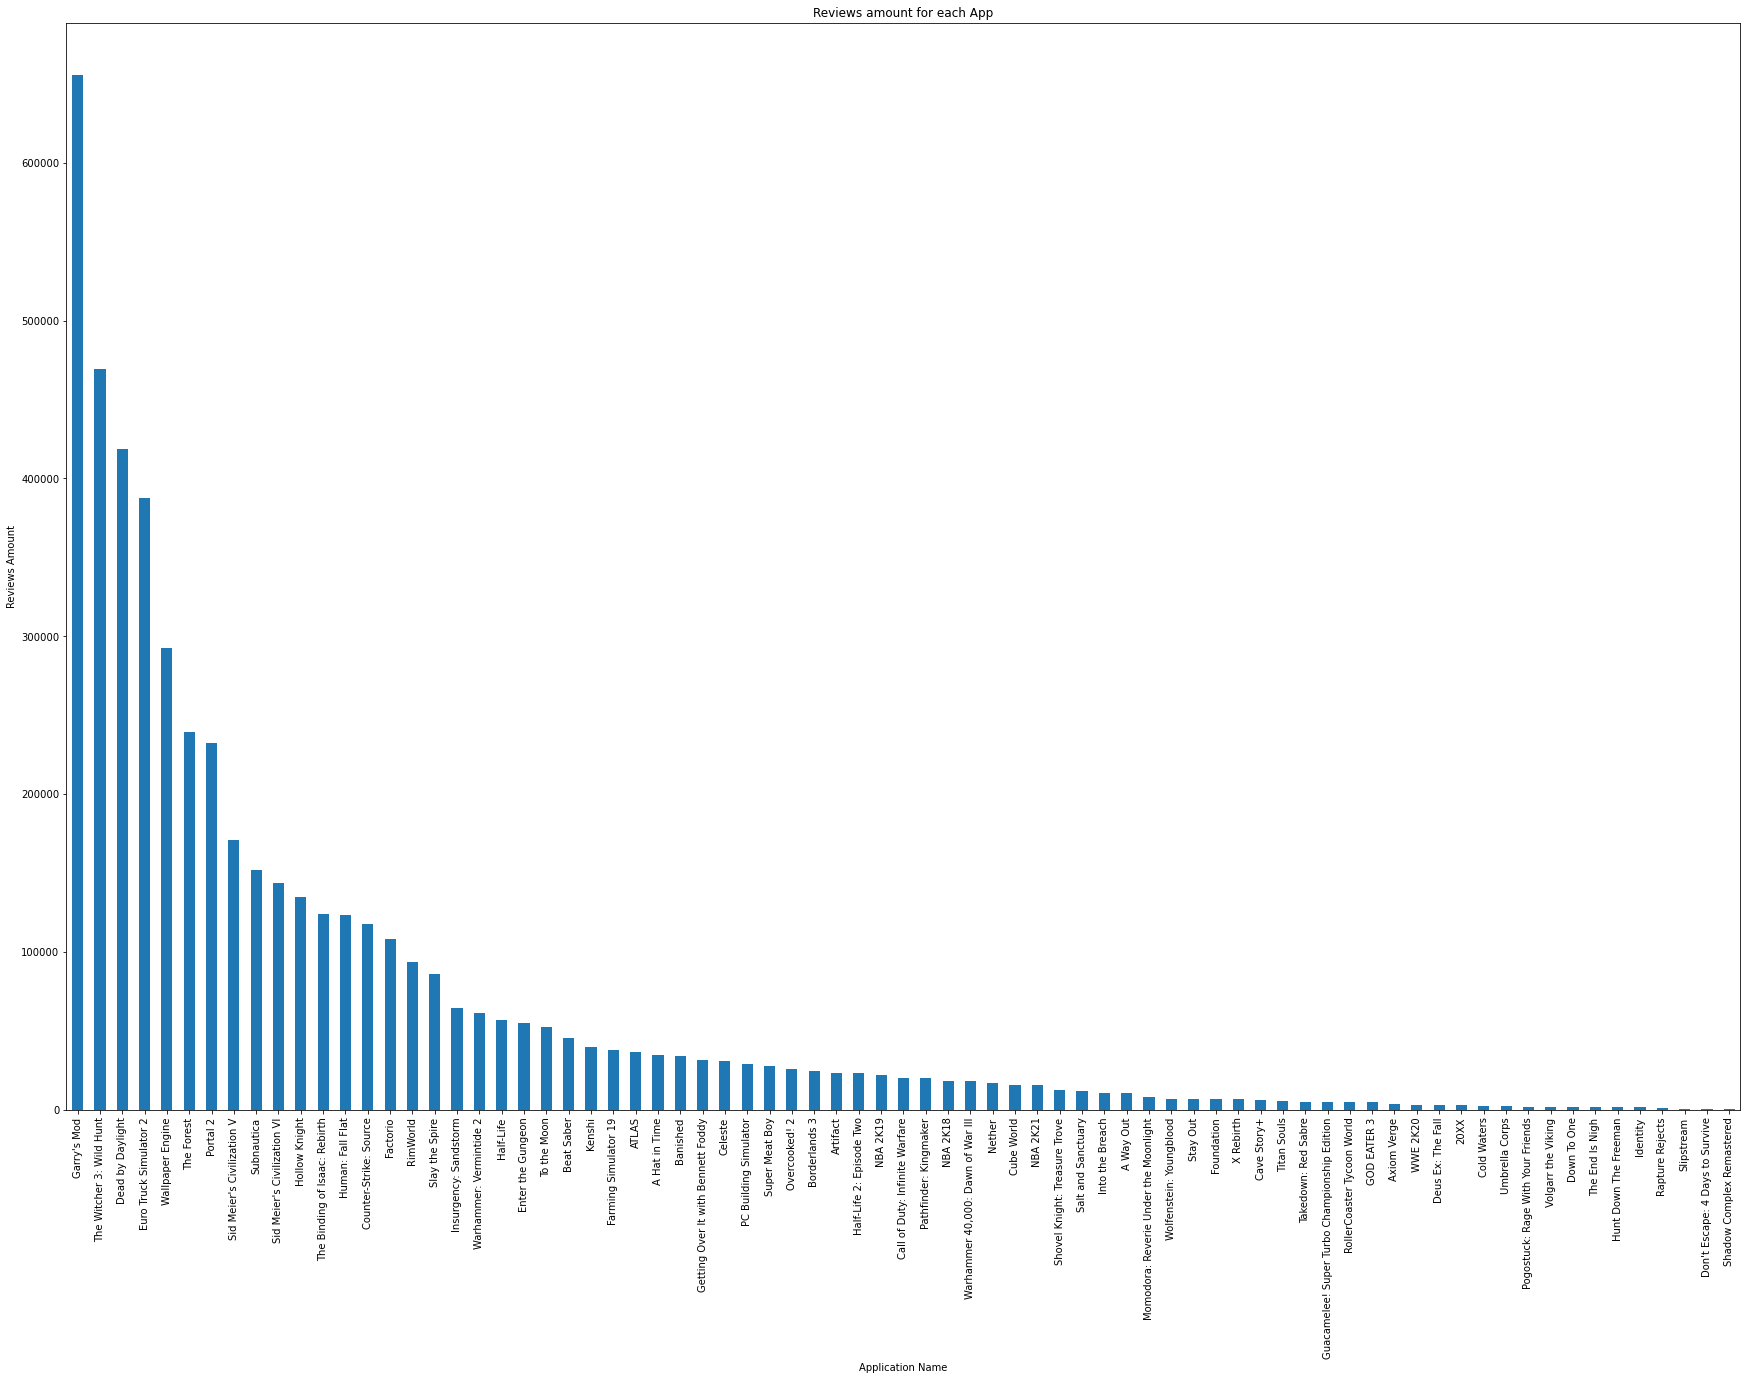

In [3]:
reviewsAmounts = dataframe['app_name'].value_counts()
ra_plot = reviewsAmounts.plot(kind='bar',
                                    figsize=(30,20),
                                    title="Reviews amount for each App")
ra_plot.set_xlabel("Application Name")
ra_plot.set_ylabel("Reviews Amount")
#plt.show()

### Find out are the most and least reviewed applications

In [4]:
print(reviewsAmounts.idxmax())
print(reviewsAmounts.idxmin())

Garry's Mod
Shadow Complex Remastered


### What applications have the best Weighted Vote Score?


In [5]:
# daframe.sort_values('weighted_vote_score')
scores = dataframe['weighted_vote_score']
max = scores.idxmax()

print(dataframe[dataframe['weighted_vote_score'] == dataframe['weighted_vote_score'].max()]['app_name'])


2353895    Subnautica
Name: app_name, dtype: object


### Which applications have the most and the least recommendations?


In [6]:
recommended = dataframe.groupby('app_name')['recommended'].apply(lambda r : (r == True).sum()).reset_index(name = 'recommendations')
max_min_recommendations = recommended[
        (recommended['recommendations'] == recommended['recommendations'].max()) |
        (recommended['recommendations'] == recommended['recommendations'].min())
      ]
print(max_min_recommendations)

       app_name  recommendations
25  Garry's Mod           632558
33     Identity              439


### How many of these applications were purchased, and how many were given for free?


In [7]:
print((dataframe)['received_for_free'].agg({'Given for free' : lambda x : (x == True).sum(), 'Purchased' : lambda y : (y == False).sum()}))

Given for free     137647
Purchased         4862353
Name: received_for_free, dtype: int64


# [RQ3]  Now it's important to understand the preferred time to do reviews.
---


### What is the most common time that authors review an application? For example, authors usually write a review at 17:44.

In [8]:
timeframes = pd.to_datetime(dataframe['timestamp_created'].apply(lambda time : (datetime.fromtimestamp(time))))

In [9]:
modes = timeframes.dt.time.mode()
print("People usually write reviews at: ")
[print(time.strftime('%H:%M') ) for time in modes.values]

People usually write reviews at: 
16:54


[None]

### Create a function that receives as a parameter a list of time intervals and returns the plot the number of reviews for each of the intervals.


In [38]:
# Counting how many datetime occurences in input_timeframes belong to each interval in intervals
#
# Parameters :
# [intervals] : List of datetime tuples (interval_start, interval_end)
# such that they define time intervals. E.G. = (06:00, 12:00). [start] has to be lesser than [end]
# [input_timeframes] : input list of (DateTime objects)
#
# Returns : A Pandas dataframe with input_timeframes grouped by intervals.
#           E.G. : 
#           '    Interval   |   Reviews    '
#           ' --------------|--------------'
#           ' 06:00 - 09:59 |    100000    '
#           ' 10:00 - 11:59 |     30000    '
#           '------------------------------'
def count_reviews_in_belonging_t_interval(intervals, input_timeframes):

    df_timeframes = pd.DataFrame()
    df_timeframes['times'] = input_timeframes
    df_timeframes.index = pd.to_datetime(input_timeframes)
    output = pd.DataFrame({'Interval' : [], 'Reviews' : []})

    for (start,end) in intervals :
        assert(start < end), 'Input Mismatch: DateTime interval had start greater than end!'
        
        start = start.strftime('%H:%M')
        end = end.strftime('%H:%M')
        r_amount = len(df_timeframes.between_time(start, end))
        output = output.append(pd.DataFrame({'Interval' : ['{}-{}'.format(start,end)], 'Reviews': [r_amount]}), ignore_index = True)
    return output


### Use the function that you created in the previous literal to plot the number of reviews between the following time intervals:

<AxesSubplot:xlabel='Interval'>

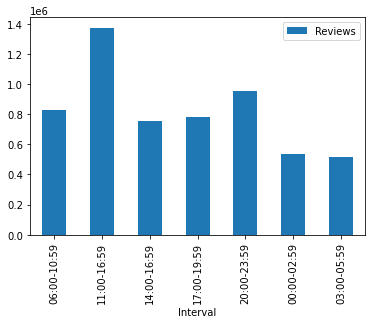

In [39]:
# Defining said intervals as datetime objects
intervals = [
    ( datetime.strptime('06:00:00', "%H:%M:%S"), datetime.strptime('10:59:59', "%H:%M:%S") ),
    ( datetime.strptime('11:00:00', "%H:%M:%S"), datetime.strptime('16:59:59', "%H:%M:%S") ),
    ( datetime.strptime('14:00:00', "%H:%M:%S"), datetime.strptime('16:59:59', "%H:%M:%S") ), 
    ( datetime.strptime('17:00:00', "%H:%M:%S"), datetime.strptime('19:59:59', "%H:%M:%S") ),
    ( datetime.strptime('20:00:00', "%H:%M:%S"), datetime.strptime('23:59:59', "%H:%M:%S") ),
    ( datetime.strptime('00:00:00', "%H:%M:%S"), datetime.strptime('02:59:59', "%H:%M:%S") ),
    ( datetime.strptime('03:00:00', "%H:%M:%S"), datetime.strptime('05:59:59', "%H:%M:%S") )
]

# Counnting how many reviews have been placed in said intervals
output = count_reviews_in_belonging_t_interval(intervals, timeframes)
output.plot(x = 'Interval', y='Reviews', kind='bar')